In [1]:
from pyspark.sql import SparkSession

import sys
sys.path.append('..')
from utils.pysparkutils import *

spark = SparkSession.builder.appName('income').getOrCreate()

In [2]:
from pyspark.sql.types import *

# schema = StructType([
#     StructField("age", IntegerType(), True), 
#     StructField("workclass", StringType(), True),
#     StructField("fnlwgt", FloatType(), True),
#     StructField("education", StringType(), True),
#     StructField("education-num", FloatType(), True),
#     StructField("marital-status", StringType(), True),
#     StructField("occupation", StringType(), True),
#     StructField("relationship", StringType(), True),
#     StructField("race", StringType(), True),
#     StructField("sex", StringType(), True),
#     StructField("capital-gain", FloatType(), True),
#     StructField("capital-loss", FloatType(), True),
#     StructField("hours-per-week", FloatType(), True),
#     StructField("native-country", StringType(), True),
#     StructField("class", StringType(), True)]
# )

# train = spark.read.csv('./adult.data.txt', schema=schema, inferSchema='true')

headers = ["age", "workclass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week", "native-country",
           "class"]

train = spark.read.csv('./adult.data.txt',
                       inferSchema='true', 
                       ignoreLeadingWhiteSpace='true',
                       ignoreTrailingWhiteSpace='true').toDF(*headers)
train.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- class: string (nullable = true)



In [3]:
from pyspark.sql.functions import udf, monotonically_increasing_id

train = train.withColumn('id', monotonically_increasing_id())

In [4]:
labelCol = 'class'
train.count()

32561

# Exploratory Data Analysis

In [5]:
train.groupby(labelCol).count().toPandas()

,class,count
0,<=50K,24720
1,>50K,7841


We can see there is a class imbalance problem in our training set.

In [6]:
findMissingValuesCols(train)

[]

There is no missing values in our training data.

In [7]:
train.select('age').distinct().show()

+---+
|age|
+---+
| 31|
| 85|
| 65|
| 53|
| 78|
| 34|
| 81|
| 28|
| 76|
| 27|
| 26|
| 44|
| 22|
| 47|
| 52|
| 86|
| 40|
| 20|
| 57|
| 54|
+---+
only showing top 20 rows



In [8]:
percentageCol = 'percentage'
df = crosstabPercentage(train, 'race', labelCol)
df = df.withColumn(percentageCol, format_number(df[percentageCol], 2))
df.toPandas()

,race,class,count,percentage
0,Amer-Indian-Eskimo,<=50K,275,88.42
1,Amer-Indian-Eskimo,>50K,36,11.58
2,Asian-Pac-Islander,<=50K,763,73.44
3,Asian-Pac-Islander,>50K,276,26.56
4,Black,<=50K,2737,87.61
5,Black,>50K,387,12.39
6,Other,<=50K,246,90.77
7,Other,>50K,25,9.23
8,White,<=50K,20699,74.41
9,White,>50K,7117,25.59


In [9]:
df = crosstabPercentage(train, 'age', labelCol)
df = df.orderBy('age').withColumn('percentage', 
                                    format_number(df['percentage'], 2))
df.toPandas()

,age,class,count,percentage
0,17,<=50K,395,100.00
1,18,<=50K,550,100.00
2,19,<=50K,710,99.72
3,19,>50K,2,0.28
4,20,<=50K,753,100.00
5,21,<=50K,717,99.58
6,21,>50K,3,0.42
7,22,<=50K,752,98.30
8,22,>50K,13,1.70
9,23,<=50K,865,98.63


In [10]:
df = crosstabPercentage(train, 'sex', labelCol)
df = df.withColumn('percentage', format_number(df['percentage'], 2))
df.toPandas()

,sex,class,count,percentage
0,Female,<=50K,9592,89.05
1,Female,>50K,1179,10.95
2,Male,<=50K,15128,69.43
3,Male,>50K,6662,30.57


`crosstabPercentage` is a simple way to explore the relation between a particular categorical feature and the label. For instance, the above shows the usefulness of `sex` feature in predicting the salary. It is obvious that more men earn >50K salary than women. So if a person is male, then he is more likely to earn >50K salary.

In [11]:
df = crosstabPercentage(train, 'education', labelCol)
df = df.withColumn('percentage', format_number(df['percentage'], 2))
df.toPandas()

,education,class,count,percentage
0,10th,<=50K,871,93.35
1,10th,>50K,62,6.65
2,11th,<=50K,1115,94.89
3,11th,>50K,60,5.11
4,12th,<=50K,400,92.38
5,12th,>50K,33,7.62
6,1st-4th,<=50K,162,96.43
7,1st-4th,>50K,6,3.57
8,5th-6th,<=50K,317,95.20
9,5th-6th,>50K,16,4.80


In [12]:
%%script false
educationNumClass = crosstabPercentage(train, 'education-num', labelCol)
educationNumClass = educationNumClass.withColumn('percentage', 
                                    format_number(educationNumClass['percentage-'], 2))
educationNumClass = educationNumClass.withColumn('education-numClassF', educationNumClass['education-numClass'].cast(DoubleType()))\
                                     .orderBy('education-numClassF').drop('education-numClass')
cols = educationNumClass.columns
cols.remove('education-numClassF')
cols.insert(0, 'education-numClassF')
educationNumClass = educationNumClass.select(cols)
educationNumClass.show()


We can see above that this is a sparse matrix, it's hard to find the non-zero values. So we will only focus on non-zero values to find out whether there is any relationship between these features and one of them is redundant.

In [13]:
%%script false

from pyspark.sql.functions import coalesce, lit, when

iterator = df.toLocalIterator()
d = {}
for row in iterator:
    rowDict = row.asDict()
    educationNum = rowDict['education-num_education']
    for k, v in rowDict.items():
        if k != 'education-num_education' and v != 0:
            d[educationNum+'_'+k] = v

import json
s = json.dumps(d, indent=4)
print(s)

We can see it's obvious that these features are redundant. Only one of them should suffice for our classification task.

Let's try more rigorous chi square test instead of something hand-wavy.

First we will define an utility method that'll index the catgorical string columns, encodes them into one-hot-encoded vectors, and finally assemble all the feature vectos into once vector for later downstream analysis.

In [14]:
df = crosstabPercentage(train, 'workclass', labelCol)
df = df.withColumn('percentage', format_number(df['percentage'], 2))
df.toPandas()

,workclass,class,count,percentage
0,?,<=50K,1645,89.60
1,?,>50K,191,10.40
2,Federal-gov,<=50K,589,61.35
3,Federal-gov,>50K,371,38.65
4,Local-gov,<=50K,1476,70.52
5,Local-gov,>50K,617,29.48
6,Never-worked,<=50K,7,100.00
7,Private,<=50K,17733,78.13
8,Private,>50K,4963,21.87
9,Self-emp-inc,<=50K,494,44.27


In [15]:
df = crosstabPercentage(train, 'hours-per-week', labelCol)
df = df.withColumn('percentage', format_number(df['percentage'], 2))
df.toPandas()

,hours-per-week,class,count,percentage
0,1,<=50K,18,90.00
1,1,>50K,2,10.00
2,2,<=50K,24,75.00
3,2,>50K,8,25.00
4,3,<=50K,38,97.44
5,3,>50K,1,2.56
6,4,<=50K,51,94.44
7,4,>50K,3,5.56
8,5,<=50K,53,88.33
9,5,>50K,7,11.67


# Outlier Detection

We will use Attribute-Value Frequency (AVF) outlier detection in categorical features. The beauty of this algorithm is that it's very simple, highly parallelizable, and fit well with distributed programming paradigm. `attributeValueFrequency` function is implemented in `pysparkutils.py` file in `utils` directory.

In [16]:
import seaborn as sns

avfScoreCol = 'avfScore'
categoricalCols = ['workclass', 'education', 'marital-status',
                  'occupation', 'relationship', 'race', 'sex',
                  'native-country']
avfScore = attributeValueFrequency(train, categoricalCols)
pdf = avfScore.groupby(avfScoreCol).count().toPandas()
pdf

,avfScore,count
0,64873,1
1,84761,1
2,85760,1
3,103252,1
4,52051,1
5,49136,1
6,91948,1
7,92741,2
8,99489,1
9,89041,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff049874978>]], dtype=object)

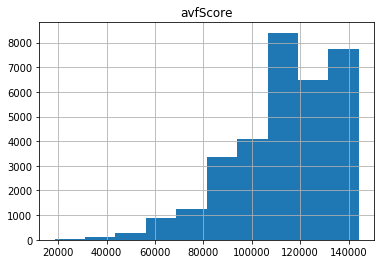

In [17]:
# sns.barplot(x="avfScore", y="count", data=pdf)
# pdf['count'].hist(by=pdf['avfScore'])
# pdf.plot(x='avfScore', y='count')
# pdf.plot(x='avfScore', y='count', kind='bar')

# Ideally, we want to use Spark for aggregation, and just plot the data by converting to 
# Pandas. Unfortuantely I couldn't figure out a way yet, visualization is not my strongest skill.
# This approach is NOT recommended for large datasets which are residing over multiple machines
# Since this will bring whole dataframe to the driver node and the driver node might run out of
# memory.
avfScore.select(avfScoreCol).toPandas().hist(avfScoreCol)

In AVF, the lower the score of a datapoint, the more likely that datapoint is an outlier. We can safely remove the rows whose score is below 70000.

In [18]:
train = avfScore.filter(col(avfScoreCol) > 70000).drop(avfScoreCol)
train.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- class: string (nullable = true)
 |-- id: long (nullable = false)



# Feature Selection

## Chi Sqaure based categorical feature selection

In [19]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml import Pipeline

indexed = train.select('education-num', 'education')

indexer = StringIndexer(inputCol='education', outputCol='educationIndexed')
indexed = indexer.fit(indexed).transform(indexed)
ohe = OneHotEncoderEstimator(inputCols=['education-num',], outputCols=['education-numOHE',])
indexed = ohe.fit(indexed).transform(indexed)

# The null hypothesis is that the occurrence of the outcomes is statistically independent.
# In general, small p-values (1% to 5%) would cause you to reject the null hypothesis. 
# This very large p-value (92.65%) means that the null hypothesis should not be rejected.
testResult = ChiSquareTest.test(indexed, 'education-numOHE', 'educationIndexed')
r = testResult.head()
print("pValues: " + str(r.pValues))

pValues: [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]


We can accept the hypothesis that features are dependent. We will drop the 'education' feature since the info. is covered

In [20]:
train = train.drop('education')

# Clustering

In [21]:
from pyspark.ml.clustering import KMeans

_, _, indexedDf =  autoIndexer(train, labelCol)

kmeans = KMeans(k=2, featuresCol='assembled')
model = kmeans.fit(indexedDf)
indexedDf = model.transform(indexedDf)
model.summary

In [22]:
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score
indexer = StringIndexer(inputCol=labelCol, outputCol=labelCol+'Indexed')
indexedDf = indexer.fit(indexedDf).transform(indexedDf)
classIndexed = [row[0] for row in indexedDf.select('classIndexed').collect()]
prediction = [row[0] for row in indexedDf.select('prediction').collect()]

adjusted_mutual_info_score(classIndexed, prediction)

0.15349812641524918

# Classification

In [23]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

stringTypes = [dtype[0] for dtype in train.dtypes if dtype[1] == 'string']
indexedTypes = [stringType+'Indexed' for stringType in stringTypes]

indexers = [StringIndexer(inputCol=stringType, outputCol=stringType+'Indexed', handleInvalid='skip') \
            for stringType in stringTypes]

In [24]:
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.classification import GBTClassifier

oheTypes = [indexedType+'OneHotEncoded' for indexedType in indexedTypes]
ohe = OneHotEncoderEstimator(inputCols=indexedTypes, outputCols=oheTypes)

# Fix columns
oheTypes.remove('classIndexedOneHotEncoded')
cols = train.columns[:]
for oheType in oheTypes:
    cols.append(oheType)
for stringType in stringTypes:
    cols.remove(stringType)

cols.remove('id')

assembler = VectorAssembler(inputCols=cols, outputCol='assembled')
classifier = GBTClassifier(featuresCol='assembled', labelCol='classIndexed')
pipeline = Pipeline(stages=[*indexers, ohe, assembler, classifier])
model = pipeline.fit(train)
train = model.transform(train)
train

DataFrame[age: int, workclass: string, fnlwgt: int, education-num: int, marital-status: string, occupation: string, relationship: string, race: string, sex: string, capital-gain: int, capital-loss: int, hours-per-week: int, native-country: string, class: string, id: bigint, workclassIndexed: double, marital-statusIndexed: double, occupationIndexed: double, relationshipIndexed: double, raceIndexed: double, sexIndexed: double, native-countryIndexed: double, classIndexed: double, workclassIndexedOneHotEncoded: vector, raceIndexedOneHotEncoded: vector, occupationIndexedOneHotEncoded: vector, relationshipIndexedOneHotEncoded: vector, native-countryIndexedOneHotEncoded: vector, marital-statusIndexedOneHotEncoded: vector, sexIndexedOneHotEncoded: vector, classIndexedOneHotEncoded: vector, assembled: vector, rawPrediction: vector, probability: vector, prediction: double]

Since we have class imbalance problem, that's why we will use area under ROC curve as metric.

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='classIndexed', metricName='areaUnderROC')
metric = evaluator.evaluate(train)
metric

0.9179985970287455

# Evaluation

In [27]:
headers = ["age", "workclass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week", "native-country",
           "class"]

test = spark.read.csv('./adult.test.txt',
                      inferSchema='true', 
                      ignoreLeadingWhiteSpace='true',
                      ignoreTrailingWhiteSpace='true').toDF(*headers)
test.select('class').limit(10).toPandas()

,class
0,<=50K.
1,<=50K.
2,>50K.
3,>50K.
4,<=50K.
5,<=50K.
6,<=50K.
7,>50K.
8,<=50K.
9,<=50K.


We can see the class labels in the test dataset are different than in train - '>50K' and '>50K.'. So we have to remove the extrac dot from the class label, before evaluating.

In [28]:
from pyspark.sql.types import StringType
stripDot = udf(lambda s: s[:-1], StringType())

test = test.withColumn('classTrailed', stripDot(test['class'])).drop('class').withColumnRenamed('classTrailed', 'class')
test.select('class').limit(10).toPandas()

,class
0,<=50K
1,<=50K
2,>50K
3,>50K
4,<=50K
5,<=50K
6,<=50K
7,>50K
8,<=50K
9,<=50K


In [29]:
test = model.transform(test)
metric = evaluator.evaluate(test)
metric


0.9096987015789428